In [ ]:
# since sift function is not supported in the latest version, we need to install the older version of opencv
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from sklearn import svm
imageId = {}
from pathlib import Path
import sklearn.metrics as metrics

In [ ]:
# Function definition for feature extraction
def feature_extract(file_path):   
    """
    This function takes in list of file paths and returns the training data and labels, by computing SIFT features.
    """
    path = '/content/drive/MyDrive/CVAss22/Train'   #path to training dataset
    c = 0   #initialize a count variable 
    X_train=[]    #initialize a list for training input
    y_train=[]    #initialize a list for training output/labels       

    for f in file_path:        
        fileStr = str(f)    #convert object to string
        Image = cv2.imread(fileStr)   #read the image    

        sift = cv2.xfeatures2d.SIFT_create()    #create SIFT object     
        keypoints, descriptors = sift.detectAndCompute(Image, None)    #compute the keypoints & descriptors for image

        fname = fileStr.replace(path, '')   #extract only the name of the file, i.e. remove the whole path till parent directory
        idx = fname.index('_')    #extract the index position of '_'
        subId = fname[:idx]   #get the subject id

        #create a dictionary for mapping image ids
        if subId not in imageId.keys():
            imageId[subId] = c
            c += 1

        num_des = 0   #number of descriptors varaible initialization

        for d in descriptors:
            if num_des <= 50:   #comparing the number of descriptors with a threshold
                X_train.append(d.astype(float))   #append the descriptor to the return data 
                y_train.append(imageId[subId])    #append image id of the subject to the labels to be returned
                num_des += 1    #increment the number of descriptors variable
            else:
                break

    return X_train, y_train   #return the data and label

In [ ]:
# Function definition for training the model, testing and displaying the results 
def model():
    """
    This function trains the model, 
    """
    train_dir='/content/drive/MyDrive/CVAss22/Train'   #path to the main train directory
    train_files = Path(str(train_dir)).rglob('*.pgm')    #object created to path of training files

    #for testing and computing accuracy
    test_dir='/content/drive/MyDrive/CVAss22/Test'   #path to the main test directory
    test_files = Path(str(test_dir)).rglob('*.pgm')    #object created to path of test files

    #same as above (for plotting roc)
    test_dir1='/content/drive/MyDrive/CVAss22/Test'   #path to the main test directory
    test_files1 = Path(str(test_dir1)).rglob('*.pgm')    #object created to path of test files

    X_train, y_train = feature_extract(train_files)   #function call to 'feature_extract' to get training data and labels

    #convert the matrices to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    classifier = svm.SVC(kernel = 'rbf', C = 10, gamma = 0.00001, probability=True)    #support vector classification with rbf (radial basis function) kernel, regularization parameter as 10, and kernel coefficient as 0.00001 
    classifier.fit(X_train, y_train)    #train the classifier, to fit the model to the training data

    sift = cv2.xfeatures2d.SIFT_create()    #create SIFT object  

    count = 0   #initializing a counter to count the number of test files
    path = '/content/drive/MyDrive/CVAss22/Test'    #path to the test dataset
    accuracy = 0    #initialize accuracy    

    for f in test_files:
        fileStr = str(f)     #convert object to string
        Image = cv2.imread(fileStr)   #read the image  
        count += 1    #increment the counter

        keypoints, descriptors = sift.detectAndCompute(Image, None)    #compute the keypoints & descriptors for image

        temp = classifier.predict(descriptors)   #predict labels for keypoints of test image
        predicted = temp.astype(np.int64)    #convert the predicted value to int64 datatype

        counts = np.bincount(predicted)      #count the occurence of each predicted value (labels assigned to keypoints)
        predicted_subId = np.argmax(counts)   #choose the subject id assigned to maximum of the keypoints

        fname = fileStr.replace(path, '')   #extract only the name of the file, i.e. remove the whole path till parent directory
        idx = fname.index('_')    #extract the index position of '_'
        subId = fname[:idx]   #get the subject id
        
        actual_subId = imageId[subId]     #assign the integer associated with the subject to actual subject id

        if actual_subId == predicted_subId:   #check if the actual subject id (ground truth) is equal to the predicted subject id
            accuracy += 1     #if yes, increment the accuracy
        
        print(fname + " - Actual subject id: " + str(actual_subId) + " - predicted subject id: " + str(predicted_subId))

    accuracy = (accuracy / count) * 100     #compute the accuracy
    print("\nAccuracy: %.2f" % accuracy + "%")

    """------------------------------------ROC curve-------------------------------------"""
    X_test1, y_test1 = feature_extract(test_files1)   #function call to 'feature_extract' to get test data and labels

    #convert the matrices to numpy array
    X_test1 = np.array(X_test1)   
    y_test1 = np.array(y_test1)

    #calculate the false positive rate (fpr) and true positive rate (tpr) for the threshold
    preds = classifier.predict_proba(X_test1)[:,1]    #predict the probabilities
    fpr, tpr, threshold = metrics.roc_curve(y_test1, preds, pos_label=1)    #receiver operating characteristics (roc) curve for the model, returns fpr, tpr and threshold
    roc_auc = metrics.auc(fpr, tpr)   #compute arear under the curve (auc), based on fpr and tpr 

    #plot the roc curve
    plt.subplots(1, figsize=(10,10))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    """The code to plot the ROC curve is referred from:
    https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python"""
    """----------------------------------------------------------------------------------"""

/1001_s19.pgm - Actual subject id: 0 - predicted subject id: 0
/1001_s110.pgm - Actual subject id: 0 - predicted subject id: 0
/10010_s1010.pgm - Actual subject id: 1 - predicted subject id: 1
/10011_s1110.pgm - Actual subject id: 2 - predicted subject id: 2
/10010_s109.pgm - Actual subject id: 1 - predicted subject id: 1
/10012_s1210.pgm - Actual subject id: 3 - predicted subject id: 3
/10014_s141.pgm - Actual subject id: 5 - predicted subject id: 5
/10013_s131.pgm - Actual subject id: 4 - predicted subject id: 4
/10015_s152.pgm - Actual subject id: 6 - predicted subject id: 6
/10016_s168.pgm - Actual subject id: 7 - predicted subject id: 7
/10017_s176.pgm - Actual subject id: 8 - predicted subject id: 8
/10019_s193.pgm - Actual subject id: 10 - predicted subject id: 10
/10018_s1810.pgm - Actual subject id: 9 - predicted subject id: 9
/1002_s210.pgm - Actual subject id: 12 - predicted subject id: 12
/1002_s29.pgm - Actual subject id: 12 - predicted subject id: 12
/10020_s2010.pgm - Ac

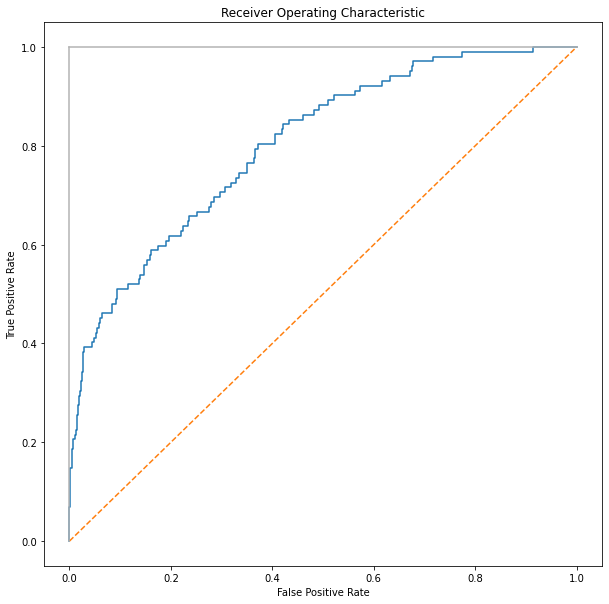

In [ ]:
model()